# 1. Pacotes e Bibliotecas

In [1]:
import pandas as pd  # Manipulação de dados
import pytz  # Fuso horários
import re  # Expressões regulares
from tqdm import tqdm  # Barra de progresso
import random  # Valores aleatórios

import nltk  # Processamento de linguagem natural
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA  # Sentiment analysis
nltk.download('vader_lexicon')  # Léxico VADER
from nltk.corpus import stopwords  # Stopwords
nltk.download('stopwords')  # Stopwords corpus

from wordcloud import WordCloud  # Word cloud

import matplotlib.pyplot as plt  # Plotagem
import seaborn as sns  # Plotagem
import plotly.express as px  # Gráficos interativos
import plotly.subplots as sp # Gráficos interativos

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# 2. Preparação

In [2]:
# Define o estilo dos gráficos
sns.set_style('darkgrid')

# Instância do SIA - SentimentIntensityAnalyzer para análise de sentimentos
sia = SIA()

# Obtém 'stopwords' do idioma inglês
stpwrds = stopwords.words('english')

# Define um mapeamento personalizado de cores
custom_colors_map = {'Negative':'#FFA07A','Neutral':'#FFFFFF', 'Positive':'#20BEFF'}

# 3. Carga

In [3]:
df = pd.read_csv('/content/drive/MyDrive/UNICAMP/Mineração de Dados/ProjetoMineracao/data.csv').iloc[:,:12]
data = df.copy()

In [4]:
# Visualização antes da transformação (base bruta)
data.head(10)

,register_index,post_id,comment_id,author,datetime,title,url,score,comments,text,author_post_karma,tag
0,1691wy8post,1691wy8,NaN,West-Ad7245,2023-09-03 16:52:41,DJI Mini 3 Pro (DJI RC) + Fly More Kit Plus $8...,https://www.reddit.com/r/technology/comments/1...,16.0,6.0,DJI Mini 3 Pro DJI RC Fly More Kit Plus 8...,NaN,Robotics/Automation
1,1691wy8jyz4h35,1691wy8,jyz4h35,CrashingAtom,2023-09-03 17:35:50,NaN,NaN,25.0,NaN,Once again the technology sub has just become ...,NaN,Robotics/Automation
2,1691wy8jyz1kik,1691wy8,jyz1kik,AnomalousBean,2023-09-03 17:19:50,NaN,NaN,2.0,NaN,https media giphy com media KBaxHrT7rkeW5ma7...,NaN,Robotics/Automation
3,1691wy8jyzahzk,1691wy8,jyzahzk,Bobthebrain2,2023-09-03 18:10:57,NaN,NaN,5.0,NaN,You get an upvote OP gets a downvote It s al...,NaN,Robotics/Automation
4,169180gjyzb77k,169180g,jyzb77k,hail_satine,2023-09-03 18:14:57,NaN,NaN,5.0,NaN,Eat glass you sanctimonious trash bag full of ...,NaN,Politics
5,169180gjyzjfjo,169180g,jyzjfjo,Zoesan,2023-09-03 19:04:08,NaN,NaN,1.0,NaN,Half of those are complete BS but go off,NaN,Politics
6,169180gjyzfrqp,169180g,jyzfrqp,TheMightyDroma,2023-09-03 18:42:04,NaN,NaN,-3.0,NaN,I see You are misusing the world tolerance ...,NaN,Politics
7,168yzqsjyzgkqg,168yzqs,jyzgkqg,cartoonist498,2023-09-03 18:46:51,NaN,NaN,0.0,NaN,The media is salivating for the day a car driv...,NaN,Transportation
8,168w60gpost,168w60g,NaN,Former_Bat_7350,2023-09-03 12:48:56,Charts: Green Demand Will Reshape Metals Marke...,https://www.reddit.com/r/technology/comments/1...,118.0,6.0,Charts Green Demand Will Reshape Metals Marke...,NaN,Energy
9,168w60gjyyshlp,168w60g,jyyshlp,Mindless_Note_5399,2023-09-03 16:25:11,NaN,NaN,2.0,NaN,Why it won t work https youtu be mIZUZRVLcP8...,NaN,Energy


# 4. Transoformação

In [5]:
# Preenche tags com 'Without Tag' em casos nulos
data.tag.fillna('Without Tag', inplace=True)

# Contagem de ocorrências para cada tag
tags = data.tag.value_counts()

# Reset do índice de 'tags' para converção em dataframe
tags = tags.reset_index()

In [6]:
# Transformação Textual
def transformation(df, mc, ac):
    # mc = Coluna principal (main_column)
    # ac = Coluna secundária (another_column)

    # Substitui casos vazios em 'mc' por 'ac'
    df[mc] = df.apply(lambda x: x[ac] if x[mc] == '' else x[mc], axis=1)

    df[mc] = df[mc].str.lower()
    df[mc] = df[mc].apply(lambda x: re.sub('@[^\s]+', '', x))
    df[mc] = df[mc].apply(lambda x: re.sub(r'\B#\S+', '', x))
    df[mc] = df[mc].apply(lambda x: re.sub(r"http\S+", "", x))
    df[mc] = df[mc].apply(lambda x: ' '.join(re.findall(r'\w+', x)))
    df[mc] = df[mc].apply(lambda x: re.sub(r'\s+[b-zA-Z]\s+', ' ', x))
    df[mc] = df[mc].apply(lambda x: re.sub(r'\s+', ' ', x, flags=re.I))
    df[mc] = df[mc].apply(lambda x: ' '.join([word for word in x.split() if word not in stpwrds]))

    df['words'] = df[mc].apply(lambda x: re.findall(r'\w+', x))
    df['words_count'] = df.words.apply(len)
    df['length'] = df[mc].apply(len)
    df['hour'] = df.datetime.apply(lambda x: x.hour)

    return df

data.datetime = pd.to_datetime(data.datetime)
data.text = data.text.astype(str)
data.title = data.title.astype(str)

data = transformation(data, 'text', 'title')

In [7]:
# Visualização após transformação (base normalizada)
data.head(10)

,register_index,post_id,comment_id,author,datetime,title,url,score,comments,text,author_post_karma,tag,words,words_count,length,hour
0,1691wy8post,1691wy8,NaN,West-Ad7245,2023-09-03 16:52:41,DJI Mini 3 Pro (DJI RC) + Fly More Kit Plus $8...,https://www.reddit.com/r/technology/comments/1...,16.0,6.0,dji mini 3 pro dji rc fly kit plus 844 today l...,NaN,Robotics/Automation,"[dji, mini, 3, pro, dji, rc, fly, kit, plus, 8...",14,62,16
1,1691wy8jyz4h35,1691wy8,jyz4h35,CrashingAtom,2023-09-03 17:35:50,nan,NaN,25.0,NaN,technology sub become advertising platform che...,NaN,Robotics/Automation,"[technology, sub, become, advertising, platfor...",7,53,17
2,1691wy8jyz1kik,1691wy8,jyz1kik,AnomalousBean,2023-09-03 17:19:50,nan,NaN,2.0,NaN,media giphy com media kbaxhrt7rkew5ma77z giphy...,NaN,Robotics/Automation,"[media, giphy, com, media, kbaxhrt7rkew5ma77z,...",7,50,17
3,1691wy8jyzahzk,1691wy8,jyzahzk,Bobthebrain2,2023-09-03 18:10:57,nan,NaN,5.0,NaN,get upvote op gets downvote,NaN,Robotics/Automation,"[get, upvote, op, gets, downvote]",5,27,18
4,169180gjyzb77k,169180g,jyzb77k,hail_satine,2023-09-03 18:14:57,nan,NaN,5.0,NaN,eat glass sanctimonious trash bag full dehydra...,NaN,Politics,"[eat, glass, sanctimonious, trash, bag, full, ...",9,59,18
5,169180gjyzjfjo,169180g,jyzjfjo,Zoesan,2023-09-03 19:04:08,nan,NaN,1.0,NaN,half complete bs go,NaN,Politics,"[half, complete, bs, go]",4,19,19
6,169180gjyzfrqp,169180g,jyzfrqp,TheMightyDroma,2023-09-03 18:42:04,nan,NaN,-3.0,NaN,see misusing world tolerance nothing tolerant ...,NaN,Politics,"[see, misusing, world, tolerance, nothing, tol...",10,74,18
7,168yzqsjyzgkqg,168yzqs,jyzgkqg,cartoonist498,2023-09-03 18:46:51,nan,NaN,0.0,NaN,media salivating day car driven ai hits pedest...,NaN,Transportation,"[media, salivating, day, car, driven, ai, hits...",14,86,18
8,168w60gpost,168w60g,NaN,Former_Bat_7350,2023-09-03 12:48:56,Charts: Green Demand Will Reshape Metals Marke...,https://www.reddit.com/r/technology/comments/1...,118.0,6.0,charts green demand reshape metals markets gre...,NaN,Energy,"[charts, green, demand, reshape, metals, marke...",9,64,12
9,168w60gjyyshlp,168w60g,jyyshlp,Mindless_Note_5399,2023-09-03 16:25:11,nan,NaN,2.0,NaN,work youtu mizuzrvlcp8 si n3 ofwq0yhvu3zpv,NaN,Energy,"[work, youtu, mizuzrvlcp8, si, n3, ofwq0yhvu3zpv]",6,42,16


In [8]:
# Quantidade de linhas e colunas
data.shape

(9433, 16)

# 5. Análise de Sentimentos

In [9]:
def sentiment_classification(x: float):
    return 'Negative' if x < -0.25 else 'Positive' if x > 0.25 else 'Neutral'

data['sentiment_eval'] = [sia.polarity_scores(x)['compound'] for x in tqdm(data['text'])]

data['class_sentiment'] = data['sentiment_eval'].apply(sentiment_classification)

100%|██████████| 9433/9433 [00:05<00:00, 1607.82it/s]


In [10]:
data.head(10)


,register_index,post_id,comment_id,author,datetime,title,url,score,comments,text,author_post_karma,tag,words,words_count,length,hour,sentiment_eval,class_sentiment
0,1691wy8post,1691wy8,NaN,West-Ad7245,2023-09-03 16:52:41,DJI Mini 3 Pro (DJI RC) + Fly More Kit Plus $8...,https://www.reddit.com/r/technology/comments/1...,16.0,6.0,dji mini 3 pro dji rc fly kit plus 844 today l...,NaN,Robotics/Automation,"[dji, mini, 3, pro, dji, rc, fly, kit, plus, 8...",14,62,16,-0.3818,Negative
1,1691wy8jyz4h35,1691wy8,jyz4h35,CrashingAtom,2023-09-03 17:35:50,nan,NaN,25.0,NaN,technology sub become advertising platform che...,NaN,Robotics/Automation,"[technology, sub, become, advertising, platfor...",7,53,17,-0.3818,Negative
2,1691wy8jyz1kik,1691wy8,jyz1kik,AnomalousBean,2023-09-03 17:19:50,nan,NaN,2.0,NaN,media giphy com media kbaxhrt7rkew5ma77z giphy...,NaN,Robotics/Automation,"[media, giphy, com, media, kbaxhrt7rkew5ma77z,...",7,50,17,0.0000,Neutral
3,1691wy8jyzahzk,1691wy8,jyzahzk,Bobthebrain2,2023-09-03 18:10:57,nan,NaN,5.0,NaN,get upvote op gets downvote,NaN,Robotics/Automation,"[get, upvote, op, gets, downvote]",5,27,18,0.0000,Neutral
4,169180gjyzb77k,169180g,jyzb77k,hail_satine,2023-09-03 18:14:57,nan,NaN,5.0,NaN,eat glass sanctimonious trash bag full dehydra...,NaN,Politics,"[eat, glass, sanctimonious, trash, bag, full, ...",9,59,18,0.0000,Neutral
5,169180gjyzjfjo,169180g,jyzjfjo,Zoesan,2023-09-03 19:04:08,nan,NaN,1.0,NaN,half complete bs go,NaN,Politics,"[half, complete, bs, go]",4,19,19,0.0000,Neutral
6,169180gjyzfrqp,169180g,jyzfrqp,TheMightyDroma,2023-09-03 18:42:04,nan,NaN,-3.0,NaN,see misusing world tolerance nothing tolerant ...,NaN,Politics,"[see, misusing, world, tolerance, nothing, tol...",10,74,18,0.0992,Neutral
7,168yzqsjyzgkqg,168yzqs,jyzgkqg,cartoonist498,2023-09-03 18:46:51,nan,NaN,0.0,NaN,media salivating day car driven ai hits pedest...,NaN,Transportation,"[media, salivating, day, car, driven, ai, hits...",14,86,18,-0.4404,Negative
8,168w60gpost,168w60g,NaN,Former_Bat_7350,2023-09-03 12:48:56,Charts: Green Demand Will Reshape Metals Marke...,https://www.reddit.com/r/technology/comments/1...,118.0,6.0,charts green demand reshape metals markets gre...,NaN,Energy,"[charts, green, demand, reshape, metals, marke...",9,64,12,-0.1280,Neutral
9,168w60gjyyshlp,168w60g,jyyshlp,Mindless_Note_5399,2023-09-03 16:25:11,nan,NaN,2.0,NaN,work youtu mizuzrvlcp8 si n3 ofwq0yhvu3zpv,NaN,Energy,"[work, youtu, mizuzrvlcp8, si, n3, ofwq0yhvu3zpv]",6,42,16,0.0000,Neutral


# 6. Análise Exploratória e Visualização

In [11]:
# Filtra registros de posts
data_post = data[data['comment_id'].isnull()]

# Filtra registros de comentários
data_comment = data[data['comment_id'].notnull()]

## 6.1 Contagem

In [12]:
# Função gráfica para composição de sentimento
def senti_plot(df, type: str):
    # type = 'post' ou 'comment'
    fig = px.histogram(
    df['class_sentiment'],
    y="class_sentiment",
    title=f'Sentiment Analysis from {type}',
    color='class_sentiment',
    color_discrete_map=custom_colors_map
    )

    # Configuração dos textos dos rótulos
    fig.update_traces(hovertemplate='%{y}<br>Count: %{x}')

    # Configurações adicionais
    fig.update_layout(template='plotly_dark', title_x=0.5, yaxis_title='Sentiment', xaxis_title='Count', legend_title='Sentiment')

    return fig

In [13]:
# Contagem por Post
senti_plot(data_post, 'Posts')

In [14]:
# Contagem por Comentário
senti_plot(data_comment, 'Comments')

## 6.2 Percentual de Sentimento por Tag

In [24]:
# Função gráfica para percentual de sentimento por tag
def tags_plot(df, type: str):
    sentiment_by_tag = df.groupby(['tag', 'class_sentiment']).size().reset_index(name='counts')

    # Transposição da base definindo 'tag' como índice, 'class_sentiment' como coluna e 'counts' como valores
    sentiment_by_tag = sentiment_by_tag.pivot(index='tag',columns='class_sentiment',values='counts').reset_index().fillna(0)

    # Total por tag
    sentiment_by_tag['Total'] = sentiment_by_tag['Negative'] + sentiment_by_tag['Neutral'] + sentiment_by_tag['Positive']

    # Percentual de sentimento para cada tag
    sentiment_by_tag['Negative'] = (sentiment_by_tag['Negative'] / sentiment_by_tag['Total']) * 100
    sentiment_by_tag['Neutral'] = (sentiment_by_tag['Neutral'] / sentiment_by_tag['Total']) * 100
    sentiment_by_tag['Positive'] = (sentiment_by_tag['Positive'] / sentiment_by_tag['Total']) * 100

    # Gráfico de barras empilhadas com base em percentuais
    fig = px.bar(
        data_frame=sentiment_by_tag,
        x='tag',
        y=['Negative', 'Neutral', 'Positive'],
        title=f'Sentiment Analysis by Tag from {type}',
        barmode='stack',
        color_discrete_map=custom_colors_map
    )

    # Configuração dos textos dos rótulos
    fig.update_traces(hovertemplate='%{x}<br>Percentage: %{y:.2f}')

    # Configurações adicionais
    fig.update_layout(template='plotly_dark', title_x=0.5, yaxis_title='Percentage', xaxis_title='Tag', legend_title='Sentiment', legend=dict(traceorder='reversed'))
    fig.for_each_trace(lambda t: t.update(name=t.name.title()))

    fig.show()

In [25]:
# Percentual por Post
tags_plot(data_post, 'Posts')

class_sentiment                      tag    Negative    Neutral   Positive  \
0                        ADBLOCK WARNING  100.000000   0.000000   0.000000   
1                Artificial Intelligence   35.000000  60.000000   5.000000   
2                          Biotechnology    0.000000  75.000000  25.000000   
3                               Business   12.500000  62.500000  25.000000   
4                                 Energy    0.000000  75.000000  25.000000   
5                               Hardware   33.333333  50.000000  16.666667   
6                     Nanotech/Materials    0.000000  66.666667  33.333333   
7                         Net Neutrality  100.000000   0.000000   0.000000   
8                     Networking/Telecom   50.000000  50.000000   0.000000   
9                               Politics   25.000000   0.000000  75.000000   
10                               Privacy   30.000000  40.000000  30.000000   
11                   Robotics/Automation   50.000000  50.000000 

In [26]:
# Percentual por Comentário
tags_plot(data_comment, 'Comments')

class_sentiment                      tag   Negative    Neutral   Positive  \
0                        ADBLOCK WARNING   0.000000  33.333333  66.666667   
1                Artificial Intelligence  26.663823  32.465870  40.870307   
2                          Biotechnology  16.438356  46.027397  37.534247   
3                               Business  22.107969  40.359897  37.532134   
4                                 Energy   9.523810  38.095238  52.380952   
5                               Hardware  20.704846  39.207048  40.088106   
6                     Nanotech/Materials   0.000000  50.000000  50.000000   
7                         Net Neutrality  29.411765  43.137255  27.450980   
8                     Networking/Telecom  19.653179  32.369942  47.976879   
9                               Politics  31.395349  43.604651  25.000000   
10                               Privacy  27.477785  41.558442  30.963773   
11                   Robotics/Automation  27.906977  44.186047  27.906977   

## 6.3 Contagem de Sentimento por Hora

In [27]:
def format_hour(h: int):
    # Formata tempo como HH:MM
    h = str(h)
    if len(h) == 1:
        h = '0' + h
    h = h + ":00"
    return h

# Função gráfica para sentimento por hora
def hourly_plot(df, type: str):
    # Agrupa a base por 'hour' e 'class_sentiment' e calcula a contagem de ocorrências
    combined_hourly = df.groupby(['hour', 'class_sentiment']).size().reset_index(name='counts')

    # Aplica a função 'format_hour' para formatar a coluna 'hour'
    combined_hourly['hour'] = combined_hourly['hour'].apply(format_hour)

    # Gera uma base de horários de 0 to 23h
    hour_base = pd.DataFrame({'hour': [format_hour(x) for x in range(0, 24)]})

    # União das bases para preencher casos de horas em que não há ocorrências com contagem = 0
    combined_hourly = pd.merge(hour_base, combined_hourly, on='hour', how='left')

    # Transposição da base definindo 'hour' como índice, 'class_sentiment' como coluna e 'counts' como valores
    combined_hourly = combined_hourly.pivot(index='hour',columns='class_sentiment',values='counts').reset_index().fillna(0)

    # Reordena as colunas do DataFrame.
    combined_hourly = combined_hourly[['hour', 'Negative', 'Neutral', 'Positive']]

    # Gráfico de barras empilhadas com base em valores
    fig = px.bar(
        data_frame=combined_hourly,
        x='hour',
        y=['Negative','Neutral','Positive'],
        title=f'Sentiment Analysis by Hour from {type}',
        barmode='stack',
        color_discrete_map=custom_colors_map
    )

    # Configuração dos textos dos rótulos
    fig.update_traces(hovertemplate='Count: %{y}')

    # Configurações adicionais
    fig.update_layout(template='plotly_dark', title_x=0.5, yaxis_title='Posts', xaxis_title='Hour', legend_title='Sentiment')
    fig.for_each_trace(lambda t: t.update(name=t.name.title()))

    # Define os rótulos das legendas
    fig.update_layout(legend=dict(traceorder='reversed'))

    fig.show()

In [28]:
# Concentração de Posts por Hora
hourly_plot(data_post, 'Posts')

class_sentiment   hour  Negative  Neutral  Positive
0                00:00       0.0      1.0       2.0
1                01:00       1.0      1.0       0.0
2                02:00       1.0      0.0       1.0
3                03:00       0.0      1.0       2.0
4                04:00       0.0      0.0       0.0
5                05:00       1.0      1.0       0.0
6                06:00       0.0      1.0       3.0
7                07:00       0.0      0.0       0.0
8                08:00       2.0      5.0       0.0
9                09:00       2.0      4.0       1.0
10               10:00       3.0      3.0       1.0
11               11:00       1.0      1.0       1.0
12               12:00       1.0      6.0       0.0
13               13:00       3.0      3.0       1.0
14               14:00       3.0      0.0       0.0
15               15:00       2.0      1.0       1.0
16               16:00       3.0      3.0       2.0
17               17:00       1.0      1.0       1.0
18          

In [29]:
# Concentração de Comentários por Hora
hourly_plot(data_comment, 'Comments')

class_sentiment   hour  Negative  Neutral  Positive
0                00:00        91      115       141
1                01:00        76      121       125
2                02:00        65      105       120
3                03:00        86      145       114
4                04:00        64      115       127
5                05:00        62      140       129
6                06:00        58       92        85
7                07:00        41       83        79
8                08:00        38       55        72
9                09:00        35       61        75
10               10:00        38       64        57
11               11:00        74       84        85
12               12:00        68      121       103
13               13:00       111      167       161
14               14:00       139      209       208
15               15:00       169      258       229
16               16:00       185      247       282
17               17:00       162      190       278
18          

## 6.4 Nuvem de Palavras

In [31]:
# Function to flatten a nested list.
def flatten_list(l):
    return [x for y in l for x in y]

# Função gráfica para nuvem individual
def generate_word_cloud(text, color_func, title, ax):
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="black", color_func=color_func).generate(text)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(title, fontsize=30)
    ax.axis("off")

# Função gráfica para nuvem agrupada (por sentimento)
def generate_word_clouds(pos_doc, neu_doc, neg_doc):
    fig, axes = plt.subplots(1, 3, figsize=(20, 10))  # 1 linha e 3 colunas

    titles = ["Positive Words", "Neutral Words", "Negative Words"]
    docs = [pos_doc, neu_doc, neg_doc]
    color_funcs = [lambda *args, **kwargs: custom_colors_map['Positive'],
                   lambda *args, **kwargs: custom_colors_map['Neutral'],
                   lambda *args, **kwargs: custom_colors_map['Negative']]

    for i, (doc, color_func, title) in enumerate(zip(docs, color_funcs, titles)):
        generate_word_cloud(" ".join(doc), color_func, title, axes[i])

    plt.tight_layout()
    plt.show()

def word_clouds(df):
    # Ordenação decrescente por 'hour'
    sentiment_sorted = df.sort_values('hour', ascending=False)

    # Top 100 palavras para cada tipo de sentimento
    positive_top_100 = sentiment_sorted[sentiment_sorted['class_sentiment'] == "Positive"].iloc[:100]
    negative_top_100 = sentiment_sorted[sentiment_sorted['class_sentiment'] == "Negative"].iloc[:100]
    neutral_top_100 = sentiment_sorted[sentiment_sorted['class_sentiment'] == "Neutral"].iloc[:100]

    # Remoção de stopwords
    cleanup = lambda x: [y for y in x.split() if y not in stpwrds]
    neg_doc = flatten_list(negative_top_100['text'].apply(cleanup))
    pos_doc = flatten_list(positive_top_100['text'].apply(cleanup))
    neu_doc = flatten_list(neutral_top_100['text'].apply(cleanup))

    # Gera nuvem de palavras
    print(neg_doc)
    generate_word_clouds(pos_doc, neu_doc, neg_doc)

### Por Post

['nvidia', 'a100', 'h100', 'banned', 'middle', 'eastern', 'countries', 'lawsuit', 'alleges', 'reddit', 'fired', 'employee', 'taking', 'medical', 'leave', 'toxic', 'culture', 'states', 'attempts', 'age', 'gate', 'internet', 'blocked', 'constitutional', 'hurdles', 'google', 'ai', 'go', 'boring', 'meetings', 'tech', 'news', 'airbase', 'project', 'could', 'pave', 'way', 'uk', 'host', 'us', 'nuclear', 'weapons', 'potential', 'surety', 'mission', 'raf', 'lakenheath', 'suffolk', 'thought', 'refer', 'return', 'nuclear', 'weapons', '15', 'years', 'hackers', 'selling', 'hacked', 'police', 'emails', 'try', 'grab', 'personal', 'data', 'many', 'criminals', 'want', 'access', 'pose', 'cops', 'make', 'fraudulent', 'emergency', 'data', 'requests', 'tiktok', 'facebook', 'discord', 'top', 'companies', '2', 'robotaxis', 'blocked', 'ambulance', 'carrying', 'patient', 'later', 'died', 'f', 'firefighters', 'say', 'ambition', 'goes', 'die', 'tech', 'workers', 'flocked', 'austin', 'pandemic', 'desperate', 'get

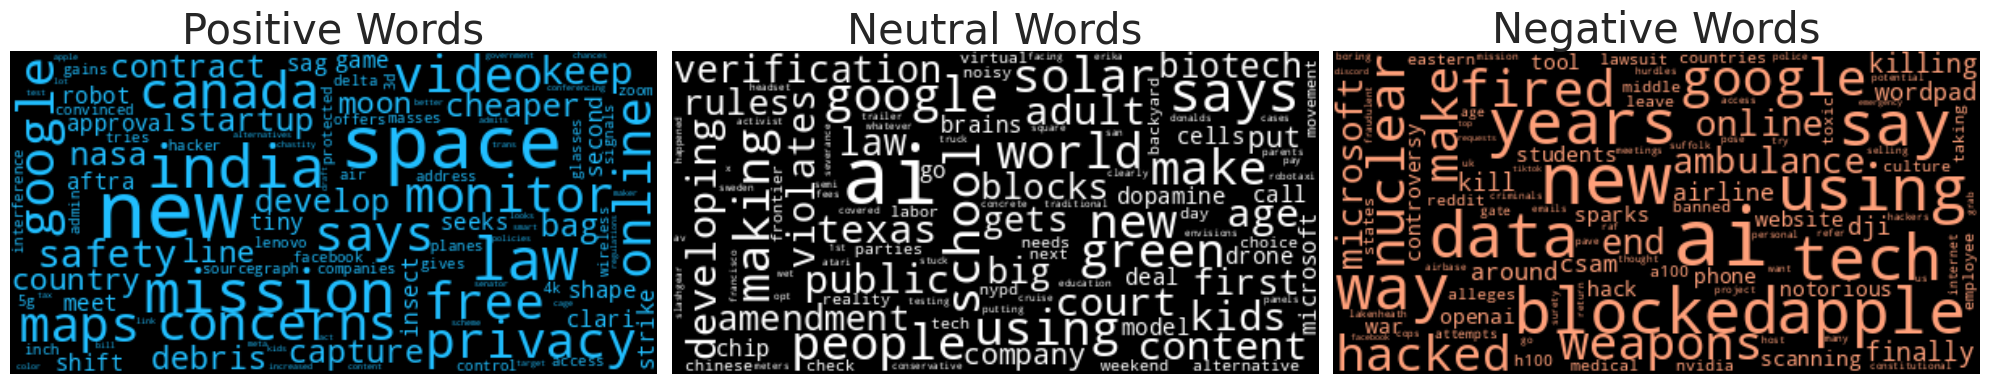

In [32]:
# Nuvem de Palavras por Post
word_clouds(data_post)

### Por Comentário

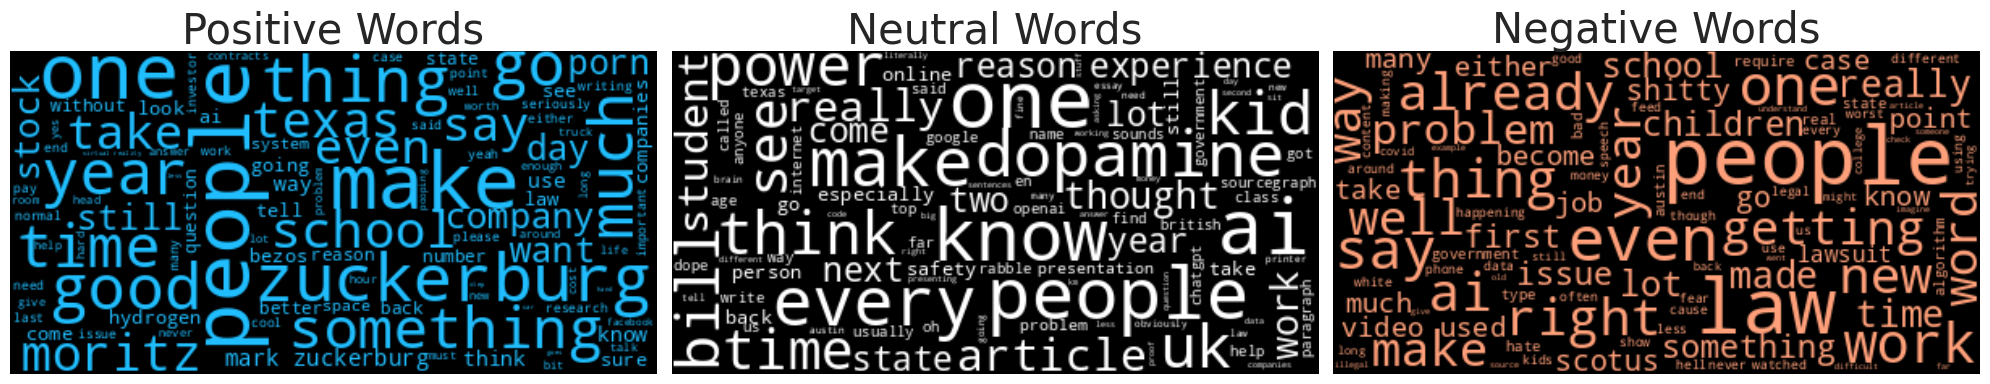

In [23]:
# Nuvem de Palavras por Comentário
word_clouds(data_comment)